In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time

from IPython import display

%matplotlib inline

pos = {}
with open('berlin52.tsp') as f:
    for i, line in enumerate(f):
        x, y = line.split()
        pos[i] = np.array([x, y], dtype=np.float64)
        #i == 9

data = np.zeros((len(pos), len(pos)))
for i in pos.keys():
    for j in pos.keys():
        data[i, j] = np.sqrt(np.sum((pos[j] - pos[i])**2))
n = len(pos)

In [2]:
def evaluate_cost(route):
    return np.sum(data[route[:-1], route[1:]])

def find_nearest_node(nodes, n):
    return nodes[np.argmin(data[nodes, n])]

def construct_cheapest_insertion(alpha, plot_graph = False, delay = 0.0, node_size = 5):
    start_point = np.random.randint(0, n)
    second_point = np.argmin(data[start_point,:]) # Inserir o segumento elemento que possua a menor distancia do primeiro
    solution = [start_point, second_point]

    if plot_graph:
        G = nx.Graph()
        G.add_nodes_from(pos.keys())
        G.add_edge(start_point, second_point)
        plt.figure(figsize=(15,15))
        plt.clf()
        nx.draw(G, pos, node_size=node_size)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(delay)

    remain_vertices = [k for k in range(n) if k not in solution]
    while remain_vertices:
        cost_array = []
        I = []
        Index = []
        for index, x in enumerate(remain_vertices):
            i = find_nearest_node(solution, x)
            j = solution[(solution.index(i) + 1) % len(solution)]
            cost_array.append(data[i,x] + data[x,j] - data[i,j])
            I.append(i)
            Index.append(index)
        gmax, gmin = np.max(cost_array), np.min(cost_array)
        LRC = np.where(cost_array <= gmin + alpha*(gmax - gmin), 1, 0)
        index = np.random.choice(np.array(Index)[np.nonzero(LRC)])
        k = remain_vertices[index]
        i = I[index]
        j = solution[(solution.index(i) + 1) % len(solution)]
        
        if plot_graph:
            G.add_edge(i, k)
            G.add_edge(k, j)
            if len(solution) > 3: G.remove_edge(j, i)
            plt.clf()
            nx.draw(G, pos, node_size=node_size)
            display.display(plt.gcf())
            display.clear_output(wait=True)
            time.sleep(delay)
        
        solution.insert((solution.index(i) + 1) % len(solution), k)
        remain_vertices.remove(k)
    return solution

def improve_2opt(initial_route):
    solution = None
    best_cost = evaluate_cost(initial_route)
    neighbor_solution = initial_route.copy()
    n = len(initial_route)
    for i in range(n):
        for j in range(i+1, n):
            neighbor_solution = neighbor_solution[:i] + list(reversed(neighbor_solution[i+1:j])) + neighbor_solution[j+1:]
            neighbor_cost = evaluate_cost(neighbor_solution)
            if neighbor_cost < best_cost:
                solution = neighbor_solution
                best_cost = neighbor_cost
    return solution

def search_neighborhood(initial_route):
    solution = None
    best_cost = evaluate_cost(initial_route)
    for i in range(n):
        neighbor_solution = initial_route.copy()
        j = (i+1) % n
        neighbor_solution[i], neighbor_solution[j] = neighbor_solution[j], neighbor_solution[i]
        cost = evaluate_cost(neighbor_solution)
        if cost < best_cost:
            best_cost = cost
            solution = neighbor_solution
            break
    return solution

def evaluate_grasp(alpha, iterations, plot_graph = False, delay = 0.0, node_size = 5):
    best_cost = np.inf
    for i in range(iterations):
        solution = construct_cheapest_insertion(alpha)
        optimal_solution = search_neighborhood(solution)
        while optimal_solution:
            solution = optimal_solution
            optimal_solution = search_neighborhood(solution)

        if plot_graph:
            G = nx.Graph()
            nx.add_path(G, solution + [solution[0]])
            plt.figure(figsize=(15, 15))
            plt.clf()
            nx.draw(G, pos, node_size=node_size)
            display.display(plt.gcf())
            display.clear_output(wait=True)
            time.sleep(delay)

        solution_cost = evaluate_cost(solution)
        if solution_cost < best_cost: best_cost = solution_cost
    return solution, best_cost

In [3]:
np.random.seed(123)
cost_array = []
for iterations in range(1, 101):
    solution, cost = evaluate_grasp(alpha = 0.1, iterations = 50, plot_graph = False, delay = 0.0)
    cost_array.append(cost)

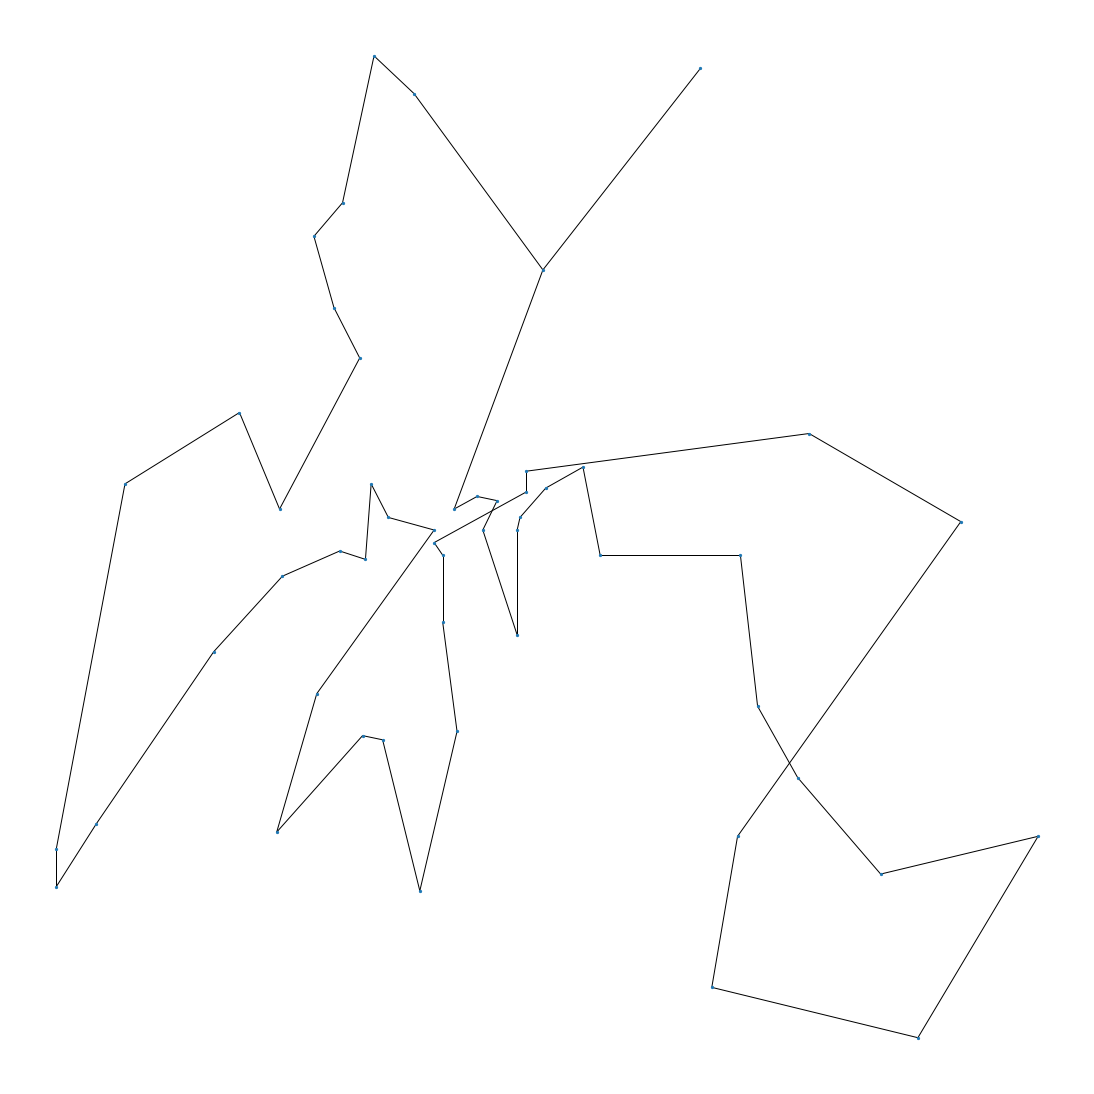

In [9]:
G = nx.Graph()
nx.add_path(G, solution + [solution[0]])
plt.figure(figsize=(15,15))
plt.clf()
nx.draw(G, pos, node_size=5)

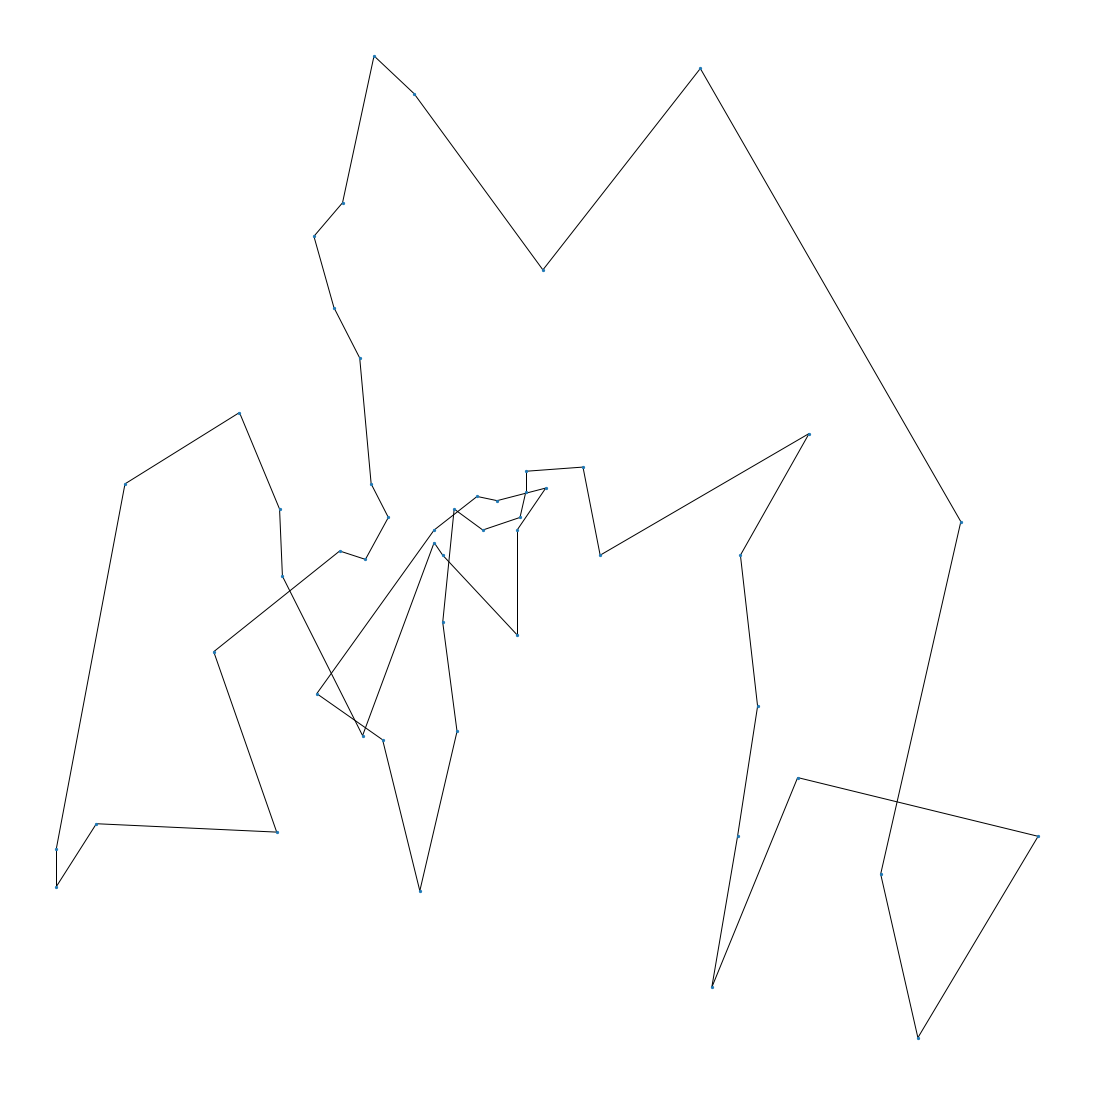

In [11]:
solution_2 = [21, 0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 10, 12, 13, 51, 26, 46, 25, 27, 11, 50, 24, 3, 14, 4, 23, 36, 38, 43, 15, 28, 49, 22, 35, 39, 37, 5, 47, 45, 33, 34, 19, 30, 17, 2, 16, 6, 1, 41, 29, 20]

G = nx.Graph()
nx.add_path(G, solution_2 + [solution_2[0]])
plt.figure(figsize=(15,15))
plt.clf()
nx.draw(G, pos, node_size=5)

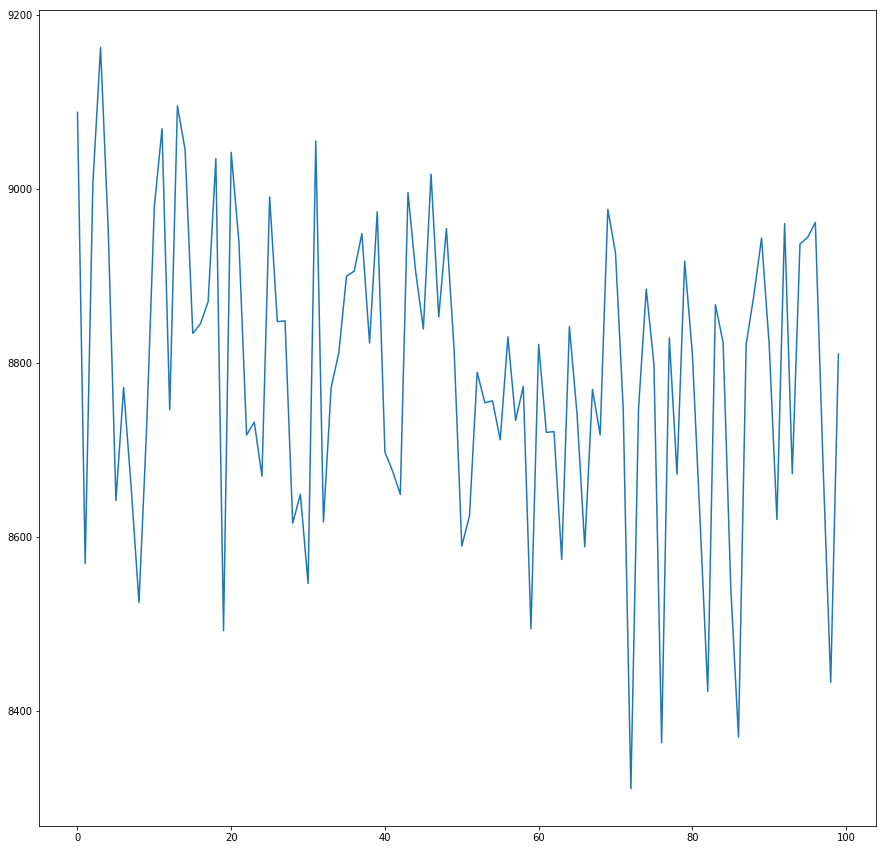

In [12]:
plt.figure(figsize=(15,15))
plt.plot(cost_array)

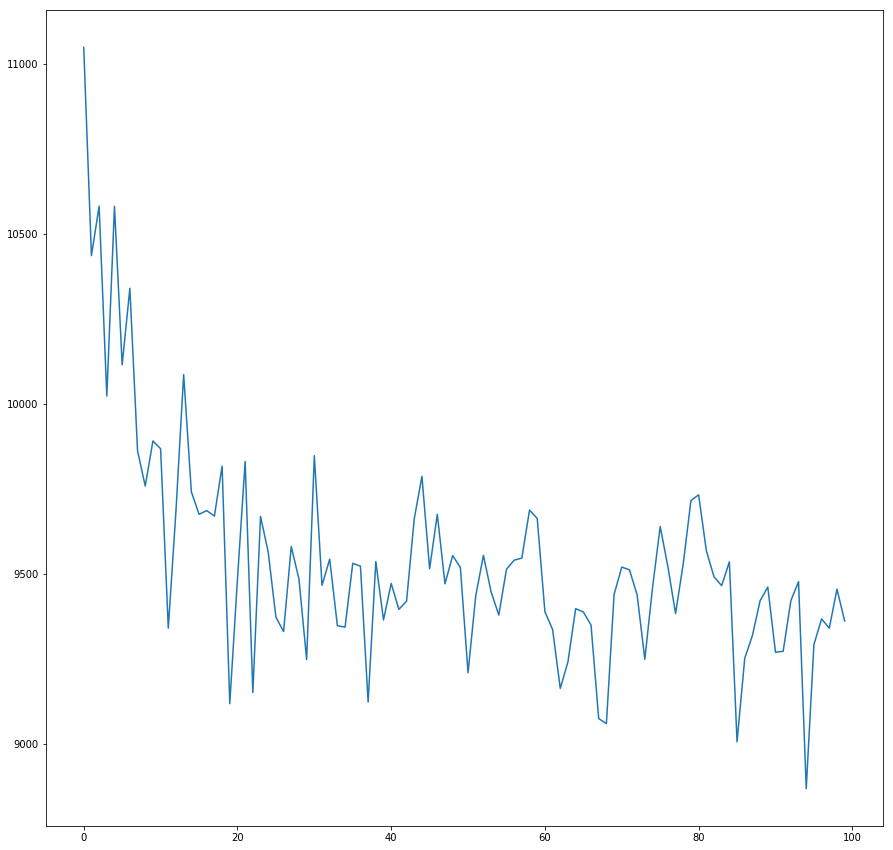

In [13]:
cost_array_2 = np.array([11047.755708732688, 10435.445062555575, 10580.943583470693, 10022.367627105157, 10580.586654538452, 10114.352917978991, 10339.466798153266, 9861.66844494862, 9757.903607647031, 9890.379631266775, 9867.627289062668, 9339.771364664493, 9685.506294559433, 10085.638415130132, 9741.116495330965, 9674.695266011768, 9685.54951521329, 9669.511230392938, 9816.40179073831, 9117.79798220281, 9484.180326278547, 9830.111372761514, 9150.404885940105, 9668.486969575855, 9563.438500441951, 9372.420274400825, 9329.899156016378, 9580.129843250246, 9484.165135902565, 9247.488259946438, 9846.979596462283, 9465.756047280913, 9542.825581542478, 9347.060527420972, 9342.788019647076, 9530.400612242478, 9522.42113821388, 9122.700600628103, 9535.596252017742, 9363.917539894985, 9471.347452872133, 9395.092160475699, 9419.174160591292, 9661.410548862481, 9786.388686480868, 9514.710167602572, 9674.560205612699, 9470.508534954139, 9553.191735382581, 9518.498233351293, 9208.678423301739, 9434.6572084295, 9554.131318035847, 9446.654133326896, 9378.38496084869, 9513.087640867345, 9539.674436819603, 9545.994441746692, 9687.107584964844, 9662.557312619425, 9388.111154697566, 9335.969795157029, 9162.690008740357, 9240.922423579548, 9397.109589409496, 9387.553563651587, 9349.065678352386, 9073.784619140039, 9059.044637996032, 9438.691734648173, 9519.415636993395, 9511.47015372978, 9437.682501542231, 9248.324009285823, 9458.235205688046, 9638.805854763948, 9520.827048244995, 9382.83111434227, 9529.453287847607, 9715.134855678081, 9731.939323445664, 9568.34004242824, 9490.942694046336, 9464.845680588522, 9534.912465443931, 9005.41608563213, 9251.349727326977, 9318.12474067274, 9420.567978681274, 9460.813509865511, 9268.839493367483, 9271.876509922273, 9420.676945246612, 9476.642651562177, 8867.54515961757, 9291.529770879653, 9367.01802384001, 9339.689936796043, 9454.545198261569, 9360.971893572754])
plt.figure(figsize=(15,15))
plt.plot(cost_array_2)